<a href="https://colab.research.google.com/github/DannyData1419/supervised-ML/blob/main/Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification

##Import libraries

In [ ]:
!pip -q install lime
!pip -q install shap
!pip -q install discern-xai==0.0.23 # required pip install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.9 MB/s eta 0:00:00


In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
import xgboost
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier as MLP
from sklearn import metrics

from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from discern.discern_tabular import DisCERNTabular

# when using MLP classifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


##Functions

###Classification report and confusion matrix function

**5-fold CV** 5-fold cross-validation is a statistical method used to evaluate the performance of a machine learning model. It helps ensure that the model is robust and generalizes well to unseen data, rather than just performing well on the specific data it was trained on.

**Data Splitting** The entire dataset is divided into 5 equally sized "folds." In each iteration, one fold is used as the test set, and the remaining four folds are combined to form the training set, this process is repeated 5 times, with each fold used exactly once as the test set.

**Model Training and Evaluation** For each of the 5 iterations, the model is trained on the training set (4 folds) and then tested on the test set (the 1 remaining fold). After each iteration, evaluation metrics such as the classification report and confusion matrix are calculated.

**Average Performance** The results from all 5 iterations (folds) are averaged to provide a more reliable estimate of the model's performance across different subsets of the data.

In [ ]:
# classification report and confusion matrix
def clasif_report_and_conf_matrix(x, y, classifier, label_mapping):
    """
    Generates a classification report and confusion matrix using 5-fold cross-validation
    """
    kf = StratifiedKFold(n_splits=5) # initializes 5-fold CV. StratifiedKFold ensures proportion of classes in each fold is approximately the same as original dataset
    confusn_matrices = [] # list to store confusion matrices
    clasif_reports = [] # list to store classification reports
    for train, test in kf.split(x, y): # iterates over each fold, generating training and test indices for each iteration
        x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y[train], y[test]
        classifier.fit(x_train, y_train) # classifier is trained on 4 folds of training data
        predictions = classifier.predict(x_test) # the trained classifier is then used to make predictions on remainin fold of test data
        y_test_text = [label_mapping[label] for label in y_test] # dictionary that maps numeric class labels to corresponding text class labels
        pred_text = [label_mapping[label] for label in predictions] #
        clasif_report = classification_report(pred_text, y_test_text)
        confusn_matrix_fold = confusion_matrix(y_test_text, pred_text, labels=list(label_mapping.values()))
        confusn_matrices.append(confusn_matrix_fold) # confusion matrix for each fold is stored
    confusn_matrix = np.mean(confusn_matrices, axis=0) # average confusion matrix from all folds
    return clasif_report, confusn_matrix

###Classification report printer

In [ ]:
# classification report printer
def classification_report_print(clasif_report, model_type, data_desc, experiment_num):
  """
  Prints a formatted classification report for a given machine learning experiment
  """
  print(f'{model_type} on {data_desc} experiment #{experiment_num}:\n')
  print(clasif_report)

###Confusion matrix printer

In [ ]:
# confusion matrix printer
def confusion_matrix_print(confusn_mtrx, model_type, data_desc, experiment_num, label_mapping):
  """
  Displays a confusion matrix plot for a given machine learning experiment
  """
  display = metrics.ConfusionMatrixDisplay(confusn_mtrx, display_labels=list(label_mapping.values()))
  display.plot()
  plt.xticks(rotation=90)
  plt.title(f'{model_type} on {data_desc} experiment #{experiment_num}')
  return plt.show()

###Plot Receiver Operating Characteristic (ROC) Curve

In [ ]:
# plot ROC curve
def plot_roc_curve(x, y, classifier, model_type, data_desc, experiment_num, label_mapping):

    kf = StratifiedKFold(n_splits=5)
    tprs = []
    aucs = []
    mean_false_pos_rate = np.linspace(0, 1, 100)

    for train, test in kf.split(x, y):
        x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y[train], y[test]
        classifier.fit(x_train, y_train)
        probas_ = classifier.predict_proba(x_test)

        # assume binary classification; hence using probas_[:, 1]
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probas_[:, 1], pos_label=list(label_mapping.keys())[1])
        roc_auc = auc(false_pos_rate, true_pos_rate)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_false_pos_rate, false_pos_rate, true_pos_rate))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_false_pos_rate, mean_tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(mean_false_pos_rate, mean_tpr, color='b',
             label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_type} on {data_desc} experiment #{experiment_num}')
    plt.legend(loc="lower right")
    plt.show()

    return mean_auc

###Plot SHAP Tree Explainer


In [ ]:
# SHAP for global feature explainability
def shap_tree_explainer(x, y, data_desc):
  """
  The shap_tree_explainer function is a comprehensive tool for training an XGBoost model on survival
  data and visualizing the feature importance using SHAP values. It handles data splitting, model
  training, and result interpretation in a single, cohesive workflow.
  """
  # model parameters
  params = {
    "eta": 0.002,                # learning rate, controls step size at each iteration
    "max_depth": 3,              # max tree depthin model
    "objective": "survival:cox", # specifies the type of model to be trained, here it's "survival," which is suitable for survival analysis
    "subsample": 0.5             # fraction of the training data to be used for training each tree
    }

  # data prep
  xgb_full = xgboost.DMatrix(x, label=y)                # converts feature matrix 'x' and labels 'y' into a DMatrix, a data structure optimized for XGBoost
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8) # 80/20 train/test split
  xgb_train = xgboost.DMatrix(x_train, label=y_train)   # training set converted into DMatrix format for XGBoost
  xgb_test = xgboost.DMatrix(x_test, label=y_test)      # testing set converted into DMatrix format for XGBoost

  # train model
  model = xgboost.train(params, xgb_train,              # trains the XGBoost model with the specified parameters
                        10000,                          # the number of boosting rounds or iterations
                        evals = [(xgb_test, "test")],   # list containing the testing set, used for evaluating model performance during training
                        verbose_eval=False)             # set to False to suppress verbose output during training

  # SHAP values calc
  # shap.TreeExplainer: creates an explainer object that can calculate SHAP values for tree-based models
  # shap_values: these values represent the contribution of each feature to the model's predictions, calculated for the entire dataset 'x'
  shap_values = shap.TreeExplainer(model).shap_values(x)

  # shap.summary_plot: generates summary plot that visualizes SHAP values, showing impact of each feature on model output, sorted by importance
  plt.title(f'XGBoost on {data_desc} for global feature importance')
  shap_summary_plot = shap.summary_plot(shap_values, x)
  return shap_summary_plot

##Import + data prep

In [ ]:
# load binary dataset for classification
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

###Dataframe info

In [ ]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

###Split data into features and target

In [ ]:
x = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

###Set GLOBAL variables

In [ ]:
# set GLOBAL variables
data_desc = 'breast cancer data'
label_mapping = {0:'malignant', 1:'benign'}

##Run experiment #1

####Set LOCAL variables

In [ ]:
# set LOCAL variables per experiment
experiment_num = '1'
model_type = 'MLP'
classifier = MLP(random_state=8, max_iter=300)

##Evaluate

In [ ]:
clasif_report, conf_matrix = clasif_report_and_conf_matrix(x, y, classifier, label_mapping)

####**Classification report**

* **Precision**: The precision for each class is the ratio of true positives (correctly predicted instances) to the sum of true positives and false positives (instances incorrectly predicted as positive). It measures the  accuracy of positive predictions. Precision is reported for each class.

* **Recall**: The recall, also known as sensitivity or true positive rate, for each class is the ratio of true positives to the sum of true positives and false negatives (instances incorrectly predicted as negative). It measures the model's ability to correctly identify positive instances. Recall is reported for each class.

* **F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. The F1-score is reported for each class. The closer it is to 1, the better the model.

* **Support**: The support indicates the number of occurrences of each class in the true labels. It represents the number of samples belonging to each class.

* **Accuracy**: The accuracy is the proportion of correctly classified instances (both true positives and true negatives) to the total number of instances. It provides an overall measure of the model's performance.

* **Macro average**: The macro average is the average of precision, recall, and F1-score across all classes. It treats all classes equally, regardless of class imbalance.

* **Weighted average**: The weighted average is the average of precision, recall, and F1-score across all classes, weighted by the support (number of samples) of each class. It considers the class imbalance and provides a more representative evaluation metric.

* [https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python](https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python)

In [ ]:
classification_report_print(clasif_report, model_type, data_desc, experiment_num)

MLP on breast cancer data experiment #1:

              precision    recall  f1-score   support

      benign       0.92      0.94      0.93        69
   malignant       0.90      0.86      0.88        44

    accuracy                           0.91       113
   macro avg       0.91      0.90      0.91       113
weighted avg       0.91      0.91      0.91       113



####**Confusion matrix**

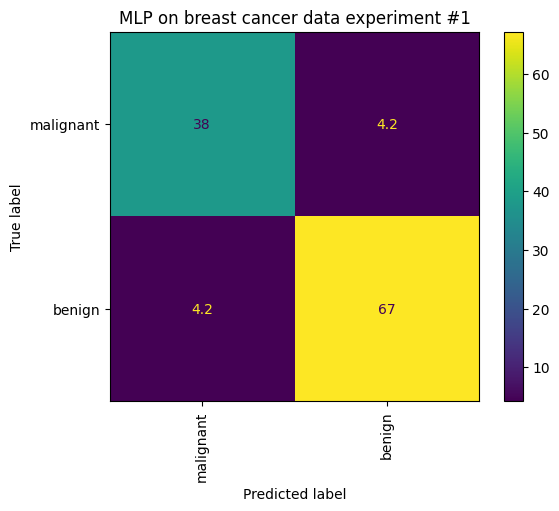

In [ ]:
confusion_matrix_print(conf_matrix, model_type, data_desc, experiment_num, label_mapping)

####**Receiver Operating Characteristic curve**

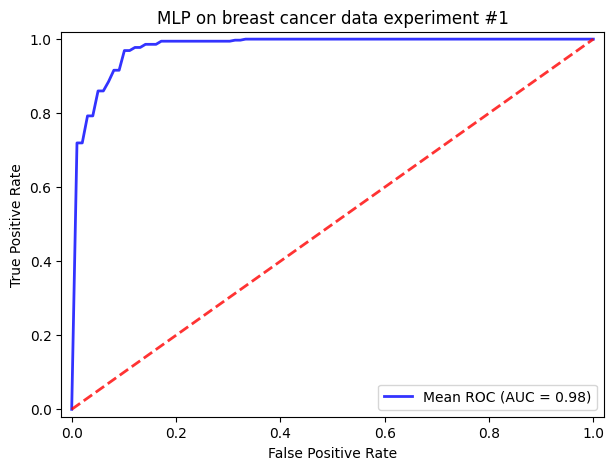

0.9770605112154409

In [ ]:
plot_roc_curve(x, y, classifier, model_type, data_desc, experiment_num, label_mapping)

###Explainability

####SHAP: SHapley Additive exPlanations (for global explainability)

* https://github.com/shap/shap?tab=readme-ov-file#sample-notebooks
* https://shap.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html
* https://github.com/shap/shap

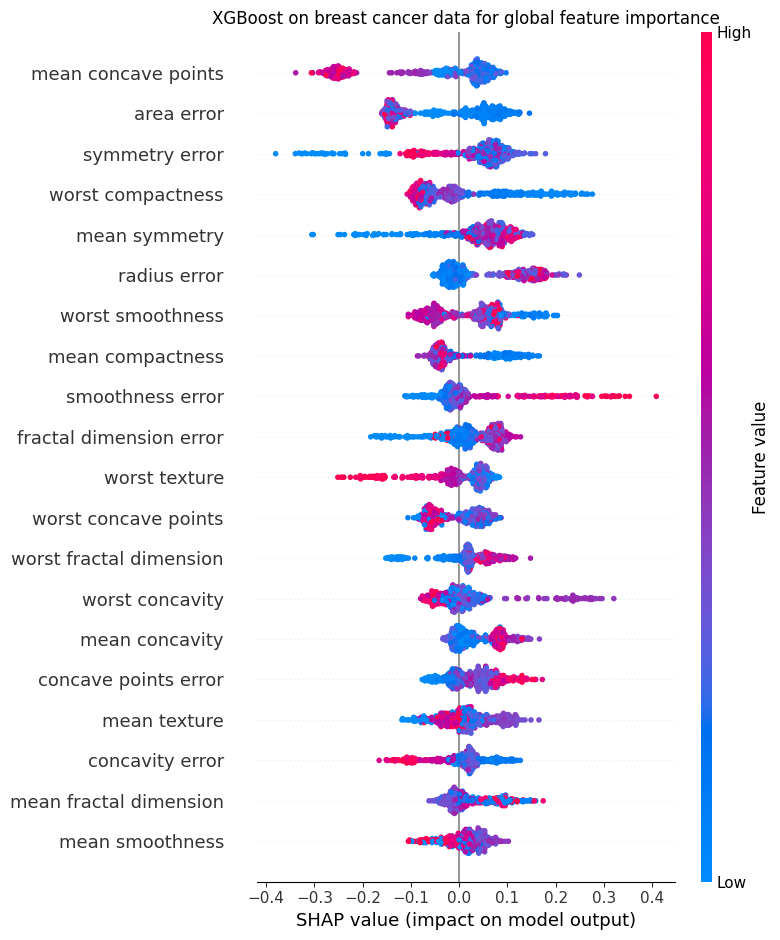

In [ ]:
shap_tree_explainer(x, y, data_desc)

####LIME: Local Interpretable Model-Agnostic Explanations (for local explainability)

In [ ]:
def lime_tab_for_classification(x, y, classifier, label_mapping, idx):
  feature_names=x.columns.tolist()
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8)
  explainer_lime = lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x.columns.tolist(), class_names=list(label_mapping.values()), verbose=True, mode='classification')
  exp = explainer_lime.explain_instance(x_test.iloc[idx], classifier.predict_proba, num_features=10)

  return exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
idx = 5

lime_tab_for_classification(x, y, classifier, label_mapping, idx)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.